# Contextual linear bandit with Thompson sampling

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax.scipy.stats import beta
from jax import random
from jax.nn import one_hot

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Context-free multi-armed Bernoulli bandit

In [3]:
def thompson_sampling_step(state, key):
    alphas, betas, probs = state
    keys = key
    K = len(alphas)
    
    # Choose an arm to pull
    # (Sample from the policy distribution)
    theta_t = random.beta(key, alphas, betas).argmax()
    # Pull the arm and observe reward (either 1 or 0)
    reward = random.bernoulli(key, probs[theta_t])
    
    # Update policy distribution
    ind_vector = one_hot(theta_t, K)
    alphas_posterior = alphas + ind_vector * reward
    betas_posterior = betas + ind_vector * (1 - reward)
    
    return (alphas_posterior, betas_posterior, probs), (alphas_posterior, betas_posterior)

In [4]:
T = 200
key = random.PRNGKey(314)
keys = random.split(key, T)
probs = jnp.array([0.65, 0.4, 0.5, 0.9])
#probs = jnp.ones(5) * 0.5
K = len(probs)


alpha_priors = jnp.ones(K) * 1
beta_priors = jnp.ones(K) * 1

init_state = (alpha_priors, beta_priors, probs)
posteriors, hist = jax.lax.scan(thompson_sampling_step, init_state, keys)
alpha_posterior, beta_posterior, _ = posteriors
alpha_hist, beta_hist = hist

alpha_posterior, beta_posterior

(DeviceArray([  8.,   9.,  18., 140.], dtype=float32),
 DeviceArray([ 4.,  7., 11., 11.], dtype=float32))

In [5]:
p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], alpha_hist[None, ...], beta_hist[None, ...])

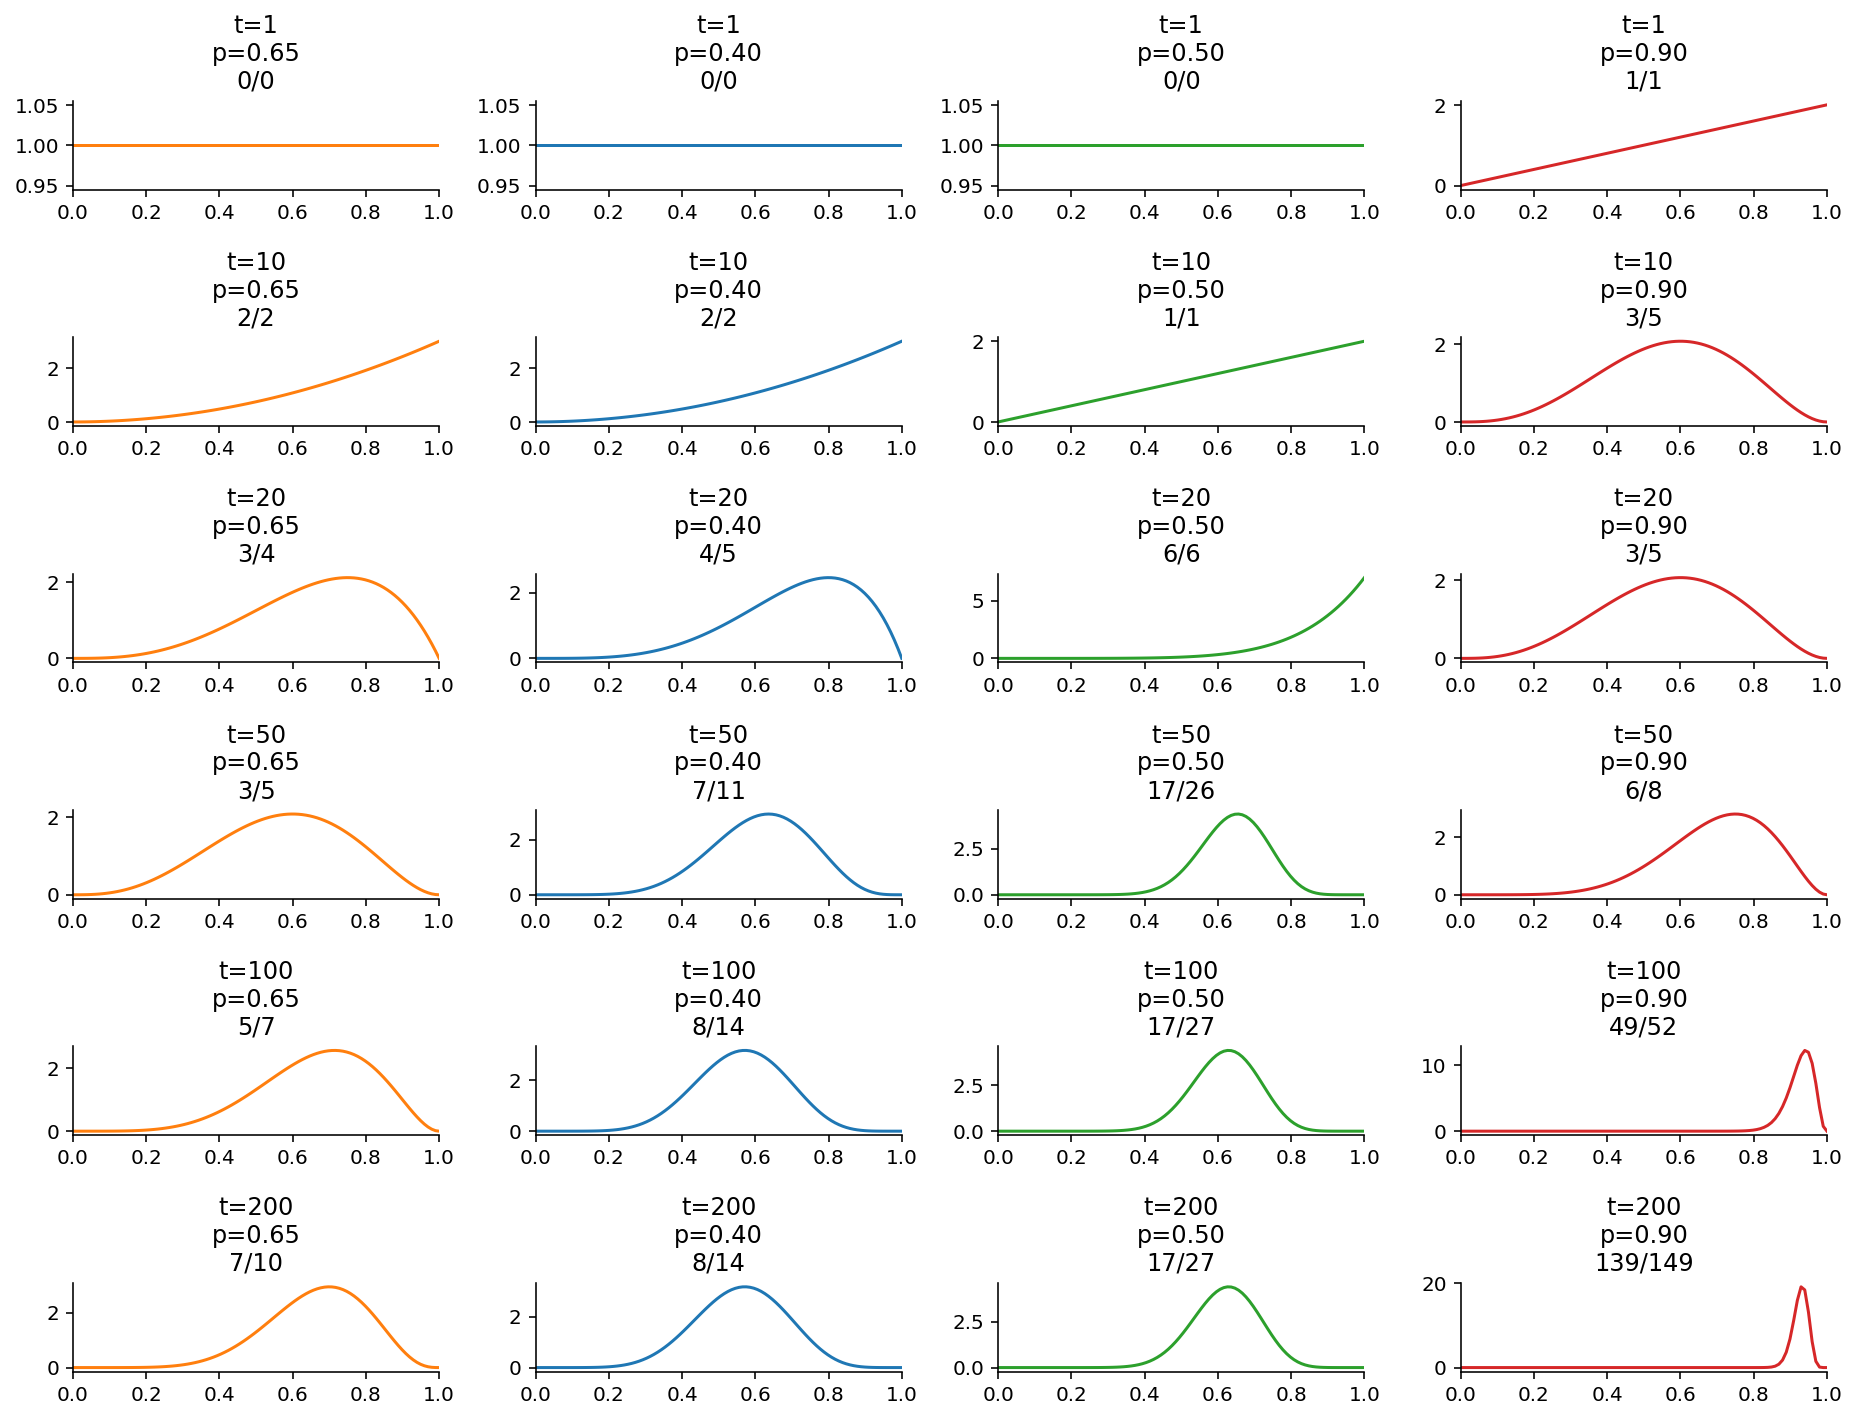

In [6]:
colors = ["orange", "blue", "green", "red"]
colors = [f"tab:{color}" for color in colors]
# Indexed by position
times = [0, 9, 19, 49, 99, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = alpha_hist[t, k].item() - 1
        n_trials = beta_hist[t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={probs[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
plt.tight_layout()

## A better API

In [7]:
from functools import partial

class BetaBernoulliBandits:
    def __init__(self, K):
        self.K = K
        
    def sample(self, key, params):
        alphas = params["alpha"]
        betas = params["beta"]
        params_sample = random.beta(key, alphas, betas)
        return params_sample
    
    def predict_rewards(self, params_sample):
        return params_sample
            
    def update(self, action, params, reward):
        alphas = params["alpha"]
        betas = params["beta"]
        # Update policy distribution
        ind_vector = one_hot(action, self.K)
        alphas_posterior = alphas + ind_vector * reward
        betas_posterior = betas + ind_vector * (1 - reward)
        return {
            "alpha": alphas_posterior,
            "beta": betas_posterior
        }


def true_reward(key, action, mean_rewards):
    """
    Reward after taking an action
    """
    reward = random.bernoulli(key, mean_rewards[action])
    return reward
    

def thompson_sampling_step(model_params, key, model, environment):
    """
    Context-free implementation of the Thompson sampling algorithm.
    This implementation considers a single step
    
    Parameters
    ----------
    model_params: dict
    environment: function
    key: jax.random.PRNGKey
    moidel: instance of a Bandit model
    """
    key_sample, key_reward = random.split(key)
    params = model.sample(key_sample, model_params)
    pred_rewards = model.predict_rewards(params)
    action = pred_rewards.argmax()
    # environment
    reward = environment(key_reward, action)
    model_params = model.update(action, model_params, reward)
    
    prob_arm = model_params["alpha"] / (model_params["alpha"] + model_params["beta"])
    
    return model_params, (model_params, prob_arm)

T = 200
key = random.PRNGKey(31415)
keys = random.split(key, T)
mean_rewards = jnp.array([0.4, 0.5, 0.2, 0.9])
K = len(mean_rewards)
bbbandit = BetaBernoulliBandits(mean_rewards)
init_params = {"alpha": jnp.ones(K),
               "beta": jnp.ones(K)}

environment = partial(true_reward, mean_rewards=mean_rewards)
thompson_partial = partial(thompson_sampling_step,
                           model=BetaBernoulliBandits(K),
                           environment=environment)
posteriors, (hist, prob_arm_hist) = jax.lax.scan(thompson_partial, init_params, keys)
prob_arm_hist = jnp.r_[jnp.ones((1, K)) * 0.5, prob_arm_hist]

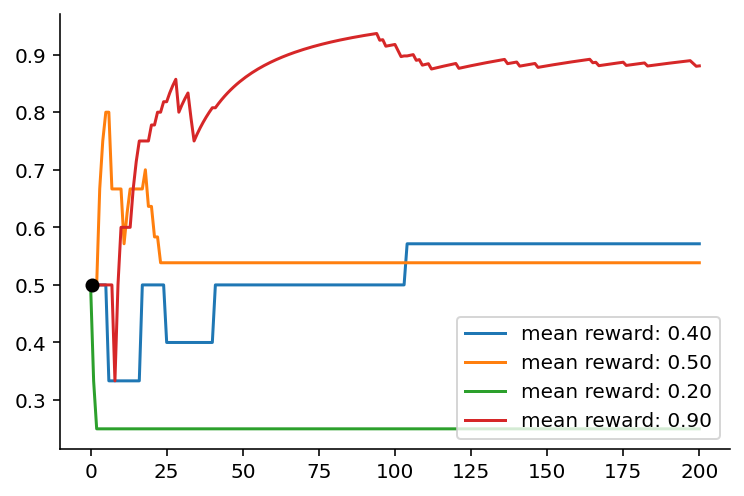

In [8]:
plt.plot(prob_arm_hist)
plt.scatter(0.5, 0.5, zorder=3, c="black")
plt.legend([f"mean reward: {reward:0.2f}" for reward in mean_rewards], loc="lower right")

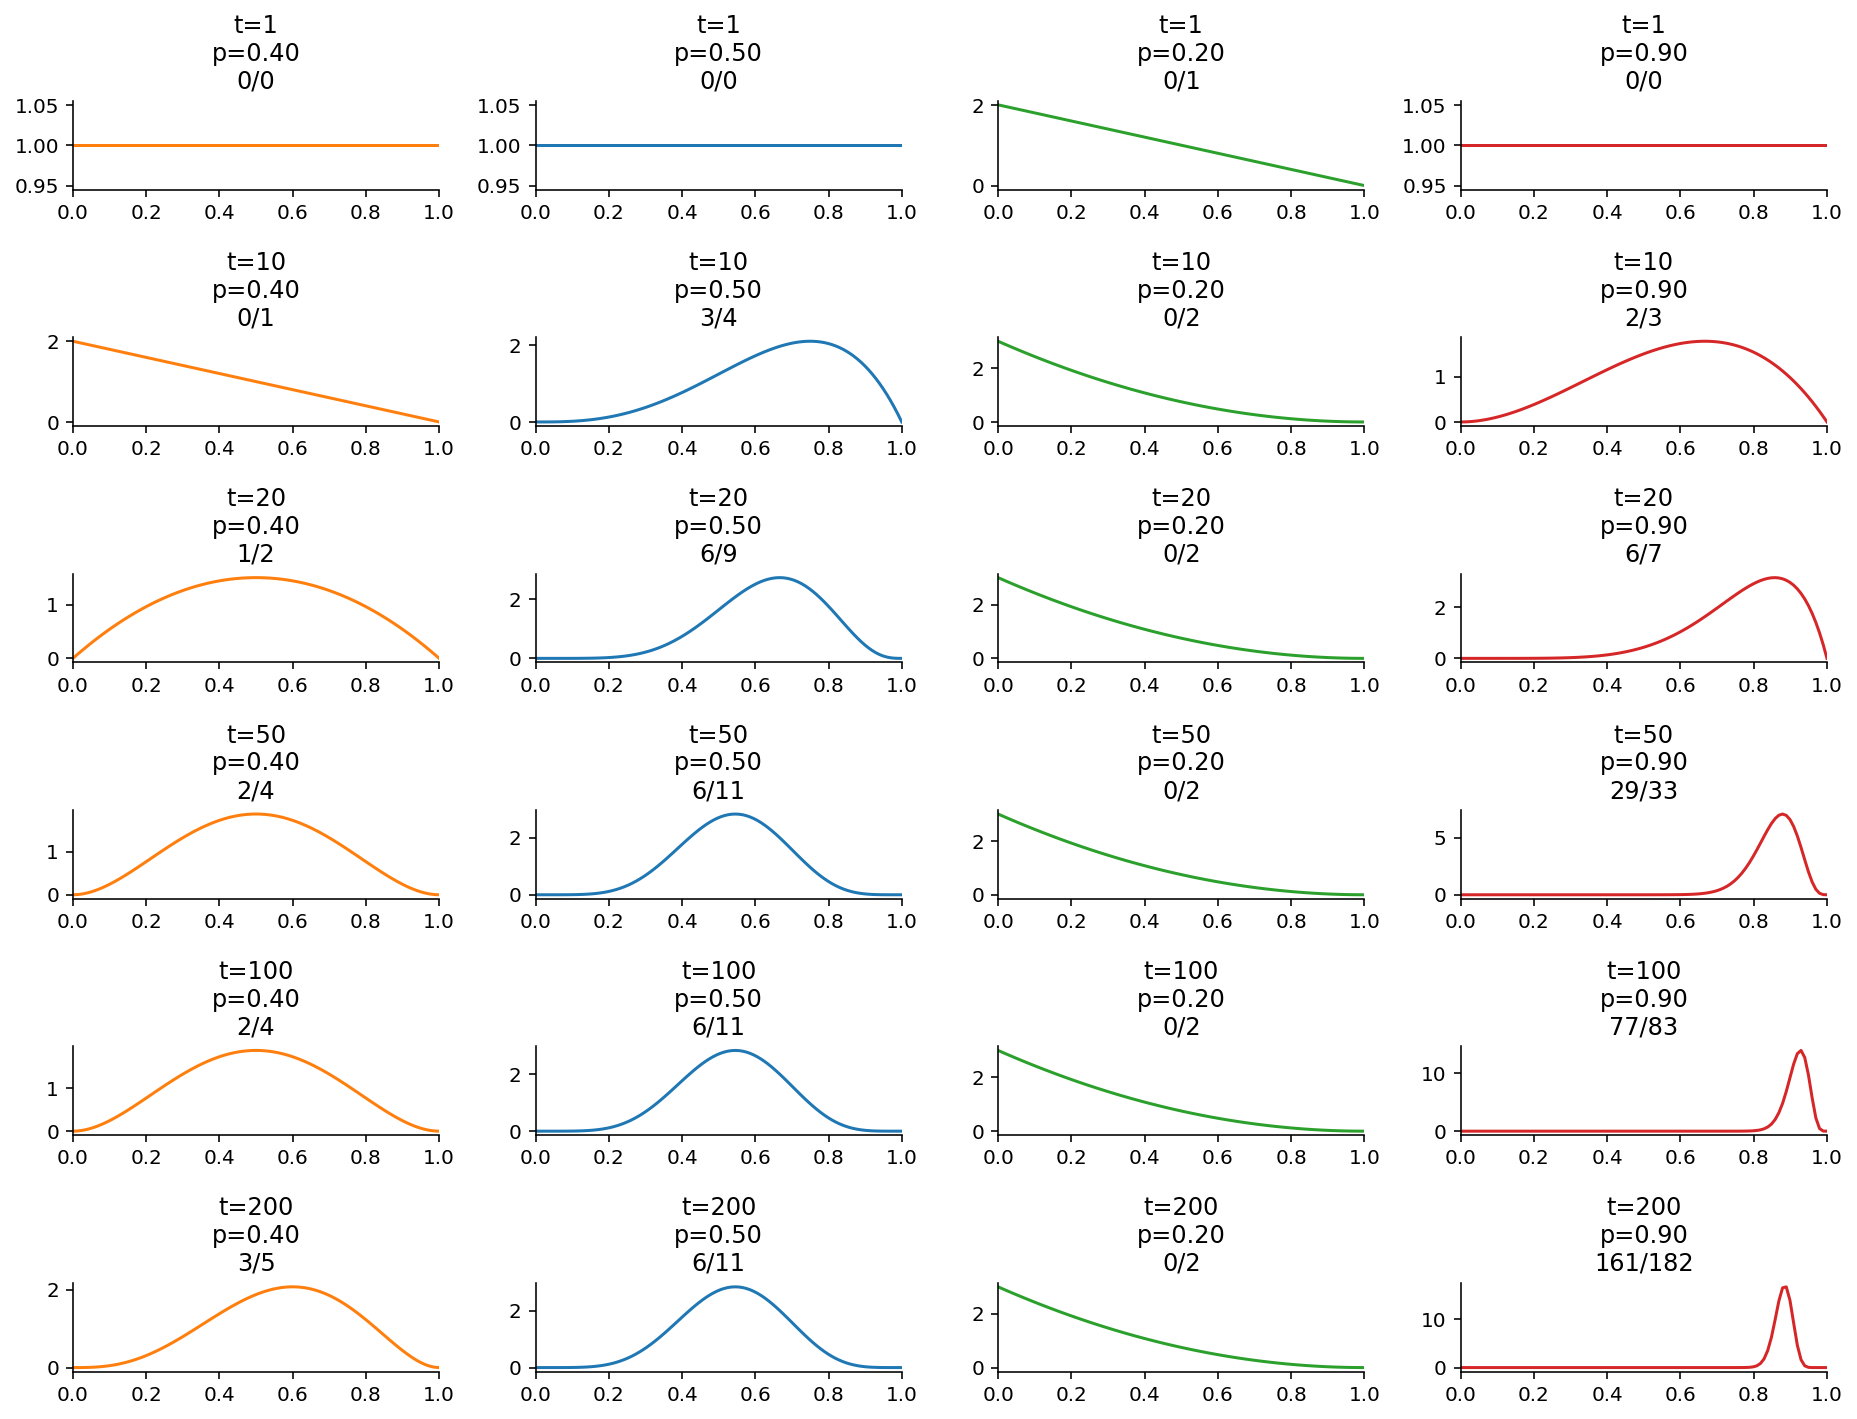

In [9]:
p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], hist["alpha"][None, ...], hist["beta"][None, ...])
colors = ["orange", "blue", "green", "red"]
colors = [f"tab:{color}" for color in colors]

# Indexed by position
times = [0, 9, 19, 49, 99, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = hist["alpha"][t, k].item() - 1
        n_trials = hist["beta"][t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={mean_rewards[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
plt.tight_layout()

In [10]:
import matplotlib.animation as animation

In [ ]:
_, n_steps, _ = bandits_pdf_hist.shape

fig, ax = plt.subplots(1, 4, figsize=(13, 2))
filepath = "./bandits.mp4"

def animate(t):
    for k, (axi, color) in enumerate(zip(ax, colors)):
        axi.cla()
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = hist["alpha"][t, k].item() - 1
        n_trials = hist["beta"][t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={mean_rewards[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
    plt.tight_layout()
    return ax

ani = animation.FuncAnimation(fig, animate, frames=n_steps)
ani.save(filepath, dpi=300, bitrate=-1, fps=10)

# Contextual multiarmed Normal bandit
## Linear case

In [457]:
import seaborn as sns
from jax.ops import index_update
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


In [458]:
class NormalGammaBandit:
    
    def sample(self, key, params, state):
        ...
    
    
    def predict_rewards(self, params_sample):
        ...
    
    
    def update(selc, action, params, reward):
        ...
        

def true_reward(self, key, action):
        ...

In [498]:
class NormalGammaBandit:
    def sample(self, key, params, state):
        key_sigma, key_w = random.split(key, 2)
        sigma2_samp = tfd.InverseGamma(concentration=params["a"], scale=params["b"]).sample(seed=key_sigma)
        cov_matrix_samples = sigma2_samp[:, None, None] * params["Sigma"]
        w_samp = tfd.MultivariateNormalFullCovariance(loc=params["mu"], covariance_matrix=cov_matrix_samples).sample(seed=key_w)
        return sigma2_samp, w_samp
        
    def predict_rewards(self, params_sample, state):
        sigma2_samp, w_samp = params_sample
        predicted_reward = jnp.einsum("m,km->k", state, w_samp)
        return predicted_reward
        
    def update(self, action, params, state, reward):
        """
        Update the parameters of the model for the
        chosen arm
        """
        mu_k = params["mu"][action]
        Sigma_k = params["Sigma"][action]
        Lambda_k = jnp.linalg.inv(Sigma_k)
        a_k = params["a"][action]
        b_k = params["b"][action]
        
        # weight params
        Lambda_update = jnp.outer(state, state) + Lambda_k
        Sigma_update = jnp.linalg.inv(Lambda_update)
        mu_update = Sigma_update @ (Lambda_k @ mu_k + state * reward)
        # noise params
        a_update = a_k + 1/2
        b_update = b_k + (reward ** 2 + mu_k.T @ Lambda_k @ mu_k - mu_update.T @ Lambda_update @ mu_update) / 2
        
        # Update only the chosen action at time t
        mu = index_update(params["mu"], action, mu_update)
        Sigma = index_update(params["Sigma"], action, Sigma_update)
        a = index_update(params["a"], action, a_update)
        b = index_update(params["b"], action, b_update)
        
        params = {
            "mu": mu,
            "Sigma": Sigma,
            "a": a,
            "b": b
        }
        
        return params
    

def true_reward(key, action, state, true_params):
    """
    Compute true reward as the linear combination
    of each set of weights and the observed state plus
    the noise from each arm
    """
    w_k = true_params["w"][action]
    sigma_k = jnp.sqrt(true_params["sigma2"][action])
    reward = w_k @ state + random.normal(key) * sigma_k
    return reward


def thompson_sampling_step(model_params, state, model, environment):
    """
    Contextual implementation of the Thompson sampling algorithm.
    This implementation considers a single step
    
    Parameters
    ----------
    model_params: dict
    environment: function
    key: jax.random.PRNGKey
    moidel: instance of a Bandit model
    """
    key, context = state
    key_sample, key_reward = random.split(key)
    # Sample an choose an action
    params = model.sample(key_sample, model_params, context)
    pred_rewards = model.predict_rewards(params, context)
    action = pred_rewards.argmax()
    # environment reward
    reward = environment(key_reward, action, context)
    model_params = model.update(action, model_params, context, reward)
    
    arm_reward = one_hot(action, K) * reward
    return model_params, (model_params, arm_reward)

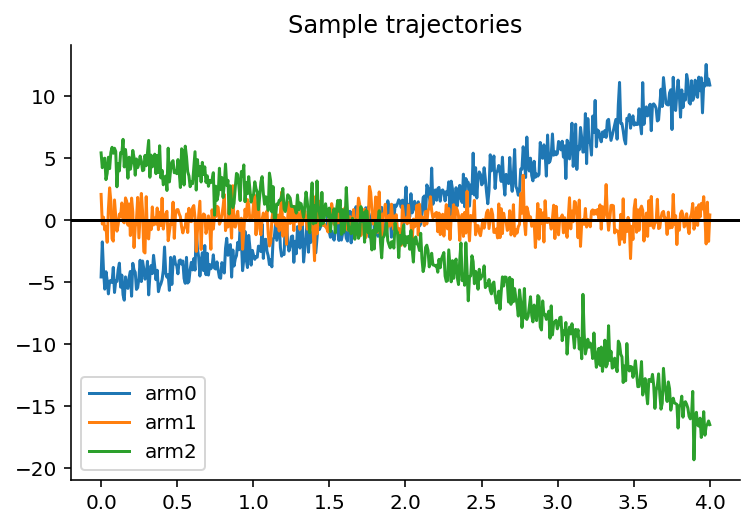

In [503]:
key = random.PRNGKey(314)

W = jnp.array([
    [-5.0, 2.0, 0.5],
    [0.0,  0.0, 0.0],
    [5.0, -1.5, -1.0]
])

sigmas = jnp.ones(3)
K, M = W.shape

N = 500
T = 4
x = jnp.linspace(0, T, N)
X = jnp.c_[jnp.ones(N), x, x ** 2]


true_params = {
    "w": W,
    "sigma2": sigmas ** 2
}


noise = random.multivariate_normal(key, mean=jnp.zeros(K), cov=jnp.eye(K) * sigmas, shape=(N,))
Y = jnp.einsum("nm,km->nk", X, W) + noise

plt.plot(x, Y)
plt.title("Sample trajectories")
plt.axhline(y=0, c="black")
plt.legend([f"arm{i}" for i in range(K)]);

In [534]:
eta = 2.0
lmbda = 5.0

# test state
state = random.normal(key, (M,))
init_params = {
    "mu": jnp.zeros((K, M)),
    "Sigma": lmbda * jnp.eye(M) * jnp.ones((K, 1, 1)),
    "a": eta * jnp.ones(K),
    "b": eta * jnp.ones(K),
}

In [535]:
key = random.PRNGKey(3141)
keys = random.split(key, N)

environment = partial(true_reward, true_params=true_params)
thompson_partial = partial(thompson_sampling_step,
                           model=NormalGammaBandit(),
                           environment=environment)


posteriors, (hist, hist_reward) = jax.lax.scan(thompson_partial, init_params, (keys, X))

Text(15.0, 0.5, 'time')

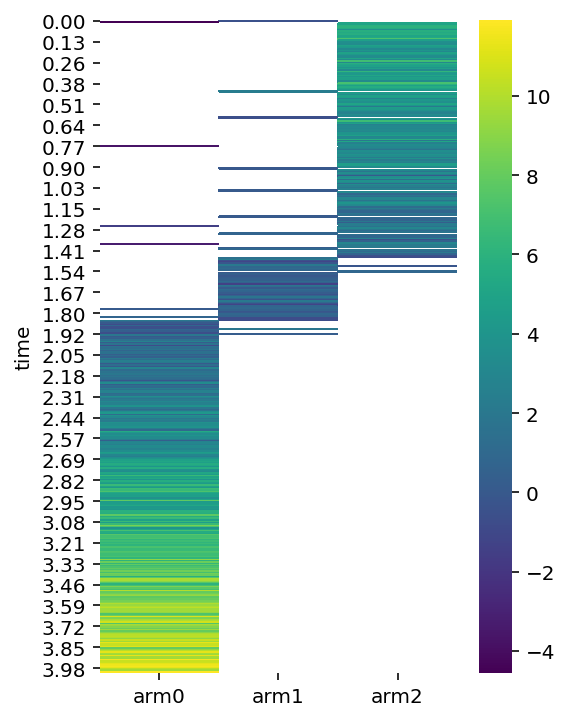

In [555]:
map_reward = hist_reward.copy()
map_reward = index_update(map_reward, map_reward==0, jnp.nan)
labels = [f"arm{i}" for i in range(K)]
map_reward_df = pd.DataFrame(map_reward, index=[f"{t:0.2f}" for t in x], columns=labels)

fig, ax = plt.subplots(figsize=(4, 6))
sns.heatmap(map_reward_df, cmap="viridis", ax=ax, xticklabels=labels);
plt.ylabel("time")

In [556]:
(~jnp.isnan(map_reward)).sum(axis=0) / N

DeviceArray([0.54800004, 0.11000001, 0.342     ], dtype=float32)

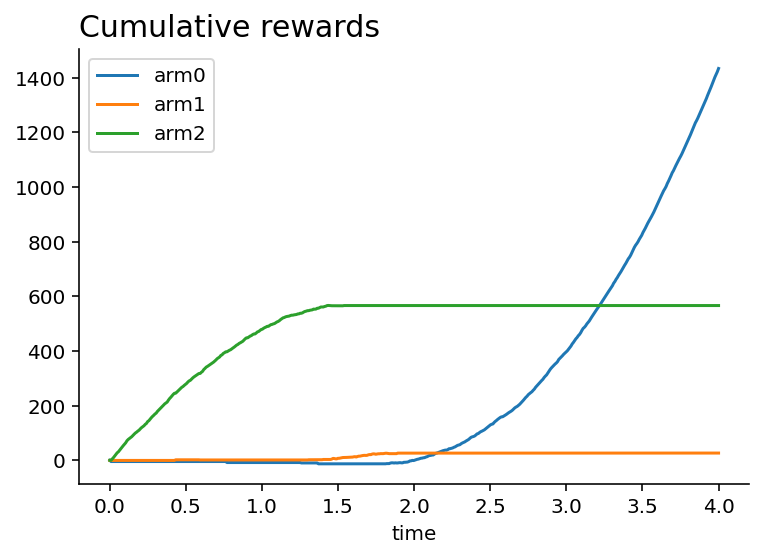

In [558]:
plt.plot(x, hist_reward.cumsum(axis=0))
plt.legend(labels, loc="upper left")
plt.title("Cumulative rewards", fontsize=15, loc="left")
plt.xlabel("time");

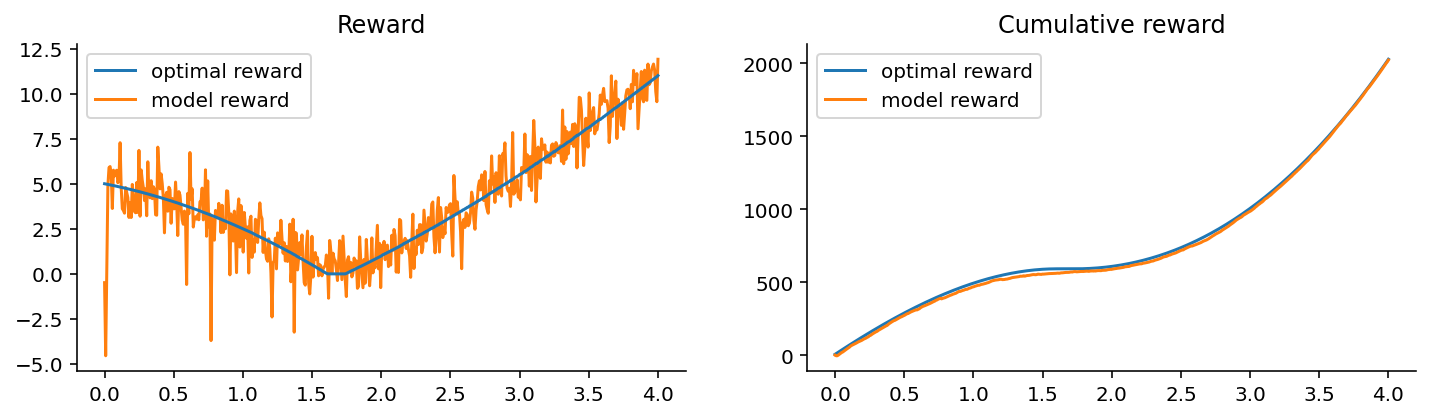

In [528]:
optimal_reward = jnp.einsum("nm,km->nk", X, true_params["w"]).max(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(x, optimal_reward, zorder=3, label="optimal reward")
ax[0].plot(x, hist_reward.sum(axis=1), label="model reward")
ax[0].set_title("Reward")
ax[0].legend()

ax[1].plot(x, optimal_reward.cumsum(), label="optimal reward")
ax[1].plot(x, hist_reward.sum(axis=1).cumsum(), label="model reward")
ax[1].set_title("Cumulative reward")
plt.legend();

## Regret

In [529]:
# To-do: try it with pmap

key = random.PRNGKey(3141)
thompson_vmap = jax.vmap(lambda key: jax.lax.scan(thompson_partial, init_params, (random.split(key, N), X)))
nsamples = 100
keys = random.split(key, nsamples)
posteriors_samples, (_, hist_reward_samples) = thompson_vmap(keys)

Text(15.0, 0.5, 'time')

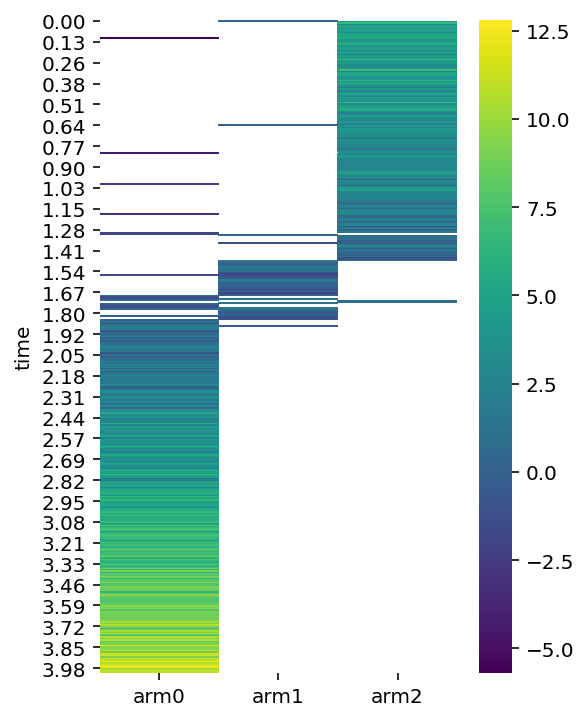

In [564]:
# Take an element to plot
ix = 0
map_reward = hist_reward_samples[ix]
map_reward = index_update(map_reward, map_reward==0, jnp.nan)
labels = [f"arm{i}" for i in range(K)]
map_reward_df = pd.DataFrame(map_reward, index=[f"{t:0.2f}" for t in x], columns=labels)

fig, ax = plt.subplots(figsize=(4, 6))
sns.heatmap(map_reward_df, cmap="viridis", ax=ax, xticklabels=labels);
plt.ylabel("time")

In [531]:
expected_hist_reward = hist_reward_samples.mean(axis=0)

optimal_reward = jnp.einsum("nm,km->nk", X, true_params["w"]).max(axis=1)

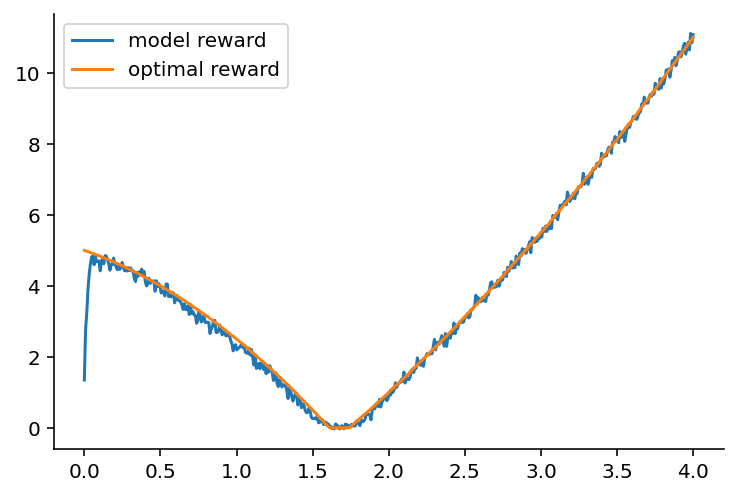

In [532]:
plt.plot(x, expected_hist_reward.max(axis=1), label="model reward")
plt.plot(x, optimal_reward, label="optimal reward")
plt.legend()

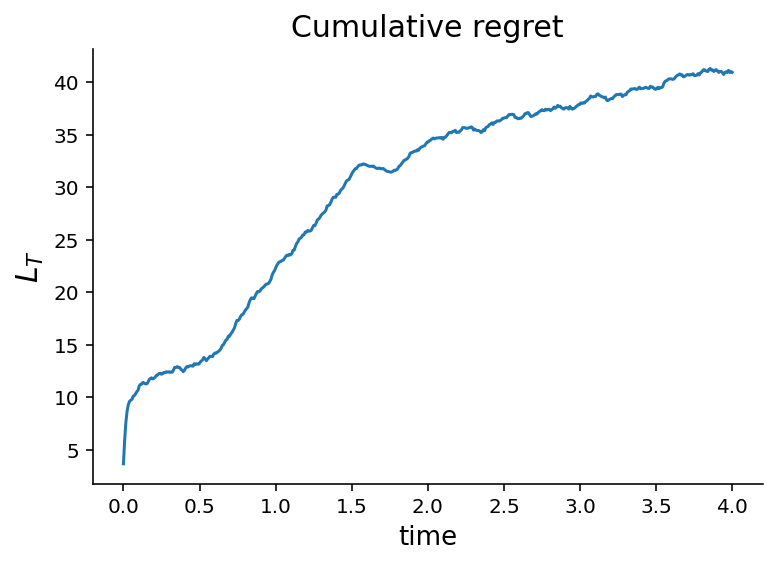

In [533]:
regret = optimal_reward - expected_hist_reward.max(axis=1)
cumulative_regret = regret.cumsum()

plt.plot(x, cumulative_regret)
plt.title("Cumulative regret", fontsize=15)
plt.ylabel("$L_T$", fontsize=15)
plt.xlabel("time", fontsize=13);

# Bandits using the [Statlog](https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)) dataset

In [338]:
import pandas as pd

We import dataset from the [`Neural-Linear-Bandits-with-Likelihood-Matching`](https://github.com/ofirnabati/Neural-Linear-Bandits-with-Likelihood-Matching) repo using the `statlog` dataset. We store in a pickle the result of the `sample_data` funtion applied to the `statlog` dataset with `context=5000`.

To see how to obtain the `.pkl` file see [this google colab notebook](https://colab.research.google.com/drive/161hGaOruJWNwunzxk0qFz2vRccXx00EF#scrollTo=X5G7q9ttfIV2)

In [487]:
import pickle
with open("statlog-bandit-data.pkl", "rb") as f:
    sampled_vals = pickle.load(f)

dataset, opt_rewards, opt_actions, num_actions, context_dim,vocab_processor = sampled_vals

In [488]:
class NormalGammaBandit:
    def sample(self, key, params, state):
        key_sigma, key_w = random.split(key, 2)
        sigma2_samp = tfd.InverseGamma(concentration=params["a"], scale=params["b"]).sample(seed=key_sigma)
        cov_matrix_samples = sigma2_samp[:, None, None] * params["Sigma"]
        w_samp = tfd.MultivariateNormalFullCovariance(loc=params["mu"], covariance_matrix=cov_matrix_samples).sample(seed=key_w)
        return sigma2_samp, w_samp
        
    def predict_rewards(self, params_sample, state):
        sigma2_samp, w_samp = params_sample
        predicted_reward = jnp.einsum("m,km->k", state, w_samp)
        
        predicted_reward = predicted_reward.argmax()
        predicted_reward = one_hot(predicted_reward, K)
        return predicted_reward
        
    def update(self, action, params, state, reward):        
        mu_k = params["mu"][action]
        Sigma_k = params["Sigma"][action]
        Lambda_k = jnp.linalg.inv(Sigma_k)
        a_k = params["a"][action]
        b_k = params["b"][action]
        
        # weight params
        Lambda_update = jnp.outer(state, state) + Lambda_k
        Sigma_update = jnp.linalg.inv(Lambda_update)
        mu_update = Sigma_update @ (Lambda_k @ mu_k + state * reward)
        # noise params
        a_update = a_k + 1/2
        b_update = b_k + (reward ** 2 + mu_k.T @ Lambda_k @ mu_k - mu_update.T @ Lambda_update @ mu_update) / 2
        
        # Update only the chosen action at time t
        mu = index_update(params["mu"], action, mu_update)
        Sigma = index_update(params["Sigma"], action, Sigma_update)
        a = index_update(params["a"], action, a_update)
        b = index_update(params["b"], action, b_update)
        
        params = {
            "mu": mu,
            "Sigma": Sigma,
            "a": a,
            "b": b
        }
        
        return params

In [489]:
def true_reward(key, action, state):
    # will return 1 if it's the correct state, 0
    # otherwise
    return state[action]


def thompson_sampling_step(model_params, state, model, environment):
    """
    Contextual implementation of the Thompson sampling algorithm.
    This implementation considers a single step
    
    Parameters
    ----------
    model_params: dict
    environment: function
    key: jax.random.PRNGKey
    moidel: instance of a Bandit model
    """
    key, context, actual_rewards = state
    key_sample, key_reward = random.split(key)
    # Sample an choose an action
    params = model.sample(key_sample, model_params, context)
    pred_rewards = model.predict_rewards(params, context)
    action = pred_rewards.argmax()
    # environment reward
    reward = environment(key_reward, action, actual_rewards)
    model_params = model.update(action, model_params, context, reward)
    
    arm_reward = one_hot(action, K) * reward
    return model_params, (arm_reward, action)

In [490]:
X = dataset[:, :-num_actions]
Y = dataset[:, -num_actions:]

N, M = X.shape
_, K = Y.shape

Phi = jnp.c_[jnp.ones(N), X]
M += 1

In [491]:
eta = 6.0
lmbda = 0.25

# test state
state = random.normal(key, (M,))
init_params = {
    "mu": jnp.zeros((K, M)),
    "Sigma": 1 * lmbda * jnp.eye(M) * jnp.ones((K, 1, 1)),
    "a": eta * jnp.ones(K),
    "b": eta * jnp.ones(K),
}

In [492]:
key = random.PRNGKey(314)
keys = random.split(key, N)

environment = true_reward
thompson_partial = partial(thompson_sampling_step,
                           model=NormalGammaBandit(),
                           environment=environment)


posteriors, (hist_reward, actions_hist) = jax.lax.scan(thompson_partial, init_params, (keys, Phi, Y))

In [493]:
jnp.array([[0, 3907], [1, 4], [2, 13], [3, 782], [4, 292], [5, 1], [6, 1]])

DeviceArray([[   0, 3907],
             [   1,    4],
             [   2,   13],
             [   3,  782],
             [   4,  292],
             [   5,    1],
             [   6,    1]], dtype=int32)

In [494]:
true_classes_count = Y.sum(axis=0)
est_classes_count = pd.Series(actions_hist).value_counts().values

jnp.stack([true_classes_count, est_classes_count], axis=1).astype(int)

DeviceArray([[3867, 3895],
             [   3,  727],
             [  21,  275],
             [ 808,   27],
             [ 297,   26],
             [   1,   25],
             [   3,   25]], dtype=int32)

In [495]:
hist_reward.sum()

DeviceArray(4497., dtype=float32)

In [496]:
(hist_reward.sum(axis=0).astype(int) / true_classes_count).round(1)

DeviceArray([1. , 0. , 0. , 0.7, 0.8, 0. , 0.3], dtype=float32)

<AxesSubplot:>

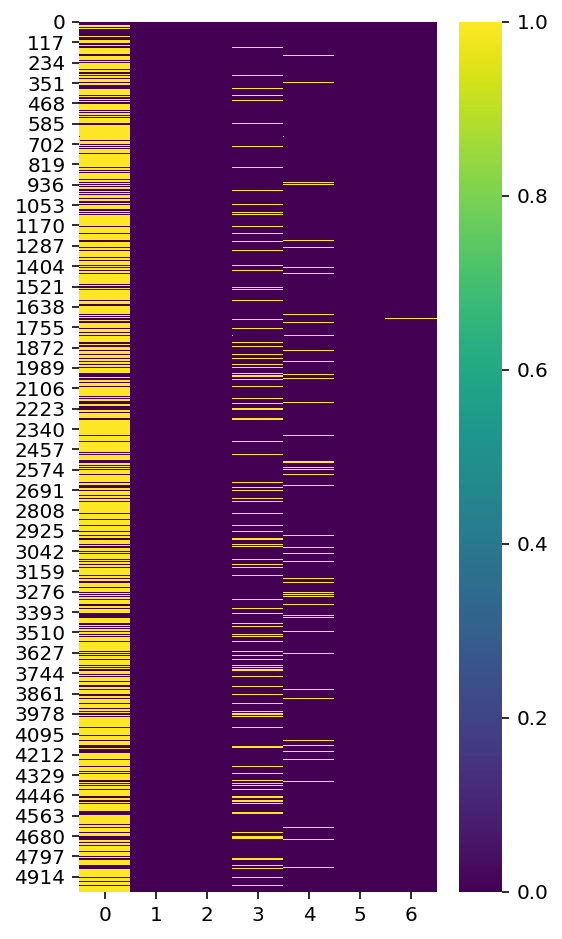

In [497]:
plt.subplots(figsize=(4, 8))
sns.heatmap(hist_reward, cmap="viridis")

## Regret Analysis

In [351]:
# To-do: try it with pmap
thompson_vmap = jax.vmap(lambda key: jax.lax.scan(thompson_partial, init_params, (random.split(key, N), Phi, Y)))

key = random.PRNGKey(3141)
nsamples = 100
keys = random.split(key, nsamples)

posteriors, (hist_reward, actions_hist) = thompson_vmap(keys)

In [387]:
rewards = hist_reward.sum(axis=1).sum(axis=1)
r_mean = rewards.mean()
r_std = rewards.std()

print(f"Expected reward {r_mean:0.2f} ± {r_std:0.2f}")

Expected reward 4480.84 ± 40.04


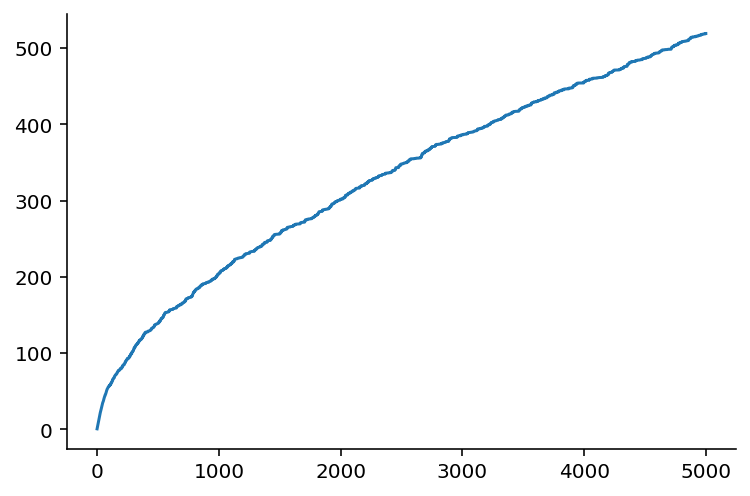

In [412]:
T = jnp.arange(1, N+1)
avg_cumulative_reward = hist_reward.mean(axis=0).sum(axis=1).cumsum()
cumulative_regret = T - avg_cumulative_reward
plt.plot(cumulative_regret)

In [414]:
std_hist = hist_reward.sum(axis=-1).std(axis=0)

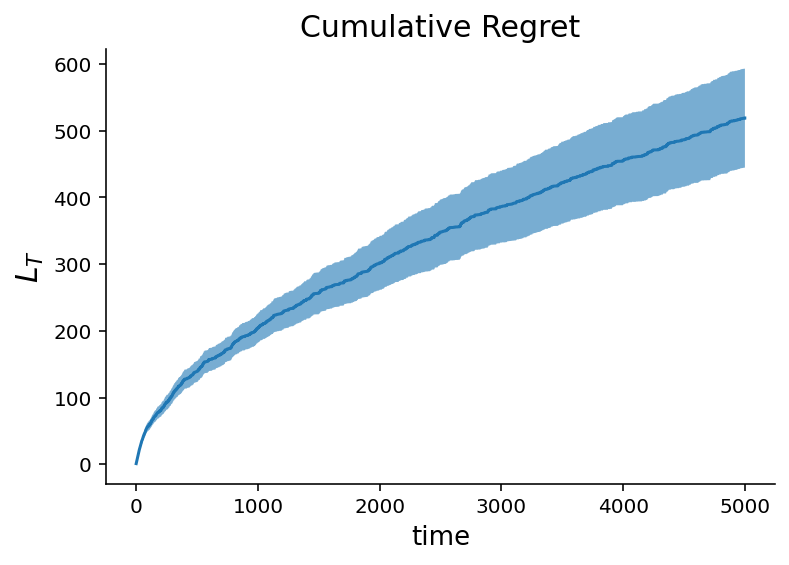

In [449]:
std_hist = hist_reward.cumsum(axis=1).std(axis=0).sum(axis=1)

avg_cumulative_reward = hist_reward.mean(axis=0).sum(axis=1).cumsum()
plt.plot(cumulative_regret)
plt.fill_between(T, cumulative_regret - std_hist, cumulative_regret + std_hist, alpha=0.6)
plt.title("Cumulative Regret", fontsize=15)
plt.xlabel("time", fontsize=13)
plt.ylabel("$L_T$", fontsize=15);

# References
* https://github.com/ofirnabati/Neural-Linear-Bandits-with-Likelihood-Matching
* https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
* [Linear full posterior sampling](https://github.com/ofirnabati/Neural-Linear-Bandits-with-Likelihood-Matching/blob/main/bandits/algorithms/linear_full_posterior_sampling.py#L83-L123)

**Tensorflow stuff**
* https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX